In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

REPO_ROOT = Path.cwd().parents[1]
PROCESSED = REPO_ROOT / "data/processed"
INTERIM = REPO_ROOT / "data/interim"
print("Using REPO_ROOT:", REPO_ROOT)
print("Processed exists:", PROCESSED.exists())

# supervised splits
customers_train = pd.read_csv(PROCESSED / "customers_train.csv")
customers_val   = pd.read_csv(PROCESSED / "customers_val.csv")
customers_test  = pd.read_csv(PROCESSED / "customers_test.csv")

# unsupervised features
unsup_train = pd.read_csv(INTERIM / "unsup_features_train.csv")
unsup_val   = pd.read_csv(INTERIM / "unsup_features_val.csv")
unsup_test  = pd.read_csv(INTERIM / "unsup_features_test.csv")

print(customers_train.shape, unsup_train.shape)


Using REPO_ROOT: c:\Users\shany\Documents\GitHub\aml-project
Processed exists: True
(700, 18) (700, 14)


In [5]:
train = customers_train.merge(unsup_train, on="customer_id")
val   = customers_val.merge(unsup_val, on="customer_id")
test  = customers_test.merge(unsup_test, on="customer_id")

print(train.shape, val.shape, test.shape)


(700, 31) (150, 31) (150, 31)


In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_scores(df, name):

    y = df["label"].values
    score = -df["anomaly_score"].values  # negative = more anomalous

    roc = roc_auc_score(y, score)
    pr  = average_precision_score(y, score)

    print(f"{name}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC:  {pr:.4f}")
    print()


evaluate_scores(train, "TRAIN")
evaluate_scores(val, "VAL")
evaluate_scores(test, "TEST")


TRAIN
ROC-AUC: 0.4137
PR-AUC:  0.0093

VAL
ROC-AUC: 0.0676
PR-AUC:  0.0106

TEST
ROC-AUC: 0.7785
PR-AUC:  0.0294



In [10]:
def lift_at_k(df, k=0.05):

    df = df.copy()
    df["score"] = -df["anomaly_score"]

    df = df.sort_values("score", ascending=False)

    top_k = df.head(int(len(df)*k))

    lift = top_k["label"].mean() / df["label"].mean()

    return lift


for k in [0.01, 0.02, 0.05, 0.1]:

    print(f"Lift@{int(k*100)}%")
    print("Train:", lift_at_k(train, k))
    print("Val:  ", lift_at_k(val, k))
    print("Test: ", lift_at_k(test, k))
    print()


Lift@1%
Train: 0.0
Val:   0.0
Test:  0.0

Lift@2%
Train: 0.0
Val:   0.0
Test:  0.0

Lift@5%
Train: 0.0
Val:   0.0
Test:  0.0

Lift@10%
Train: 0.0
Val:   0.0
Test:  0.0



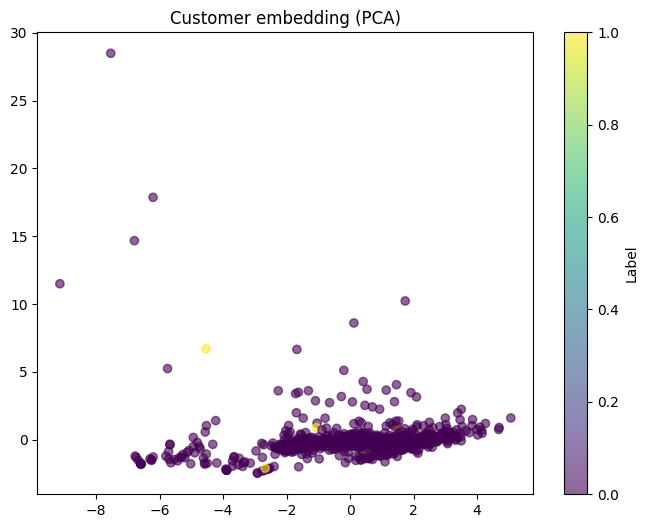

In [11]:
plt.figure(figsize=(8,6))

plt.scatter(
    train["pca_1"],
    train["pca_2"],
    c=train["label"],
    alpha=0.6
)

plt.title("Customer embedding (PCA)")
plt.colorbar(label="Label")
plt.show()


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

features = [
    "pca_1","pca_2","pca_3","pca_4","pca_5",
    "pca_6","pca_7","pca_8","pca_9","pca_10",
    "cluster_id",
    "cluster_dist",
    "anomaly_score"
]

X_train = train[features]
y_train = train["label"]

X_val = val[features]
y_val = val["label"]

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict_proba(X_val)[:,1]

print("ROC-AUC:", roc_auc_score(y_val, pred))
print("PR-AUC:", average_precision_score(y_val, pred))


ROC-AUC: 0.44594594594594594
PR-AUC: 0.031802721088435376
